## Multivariate Linear Regression

Building on our univariate linear regression model, we will take a look at the multivariate case. Our sample dataset contains housing prices for Portland, Oregon. Features consist of size (square footage) and # of bedrooms.

In [39]:
import numpy as np
from numpy.linalg import pinv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def scale_features(X, means=None, stds=None):
    """Scale initial X matrix columns as (x - mean)/std."""
    if means is None and stds is None:
        means = X.mean(axis=0)
        stds = X.std(axis=0)
    X = (X - means) / stds
    return X, means, stds

In [93]:
def cost(X, y, theta):
    """Calculate adjusted MSE for given theta."""
    m = X.shape[0]
    error = y - (X @ theta)
    sse = error @ error.T
    return sse / (2 * m)

In [171]:
def gradient_descent(X, y, theta, alpha, iterations, min_improvement=0.00001):
    """Run given # of iterations of gradient descent, starting with theta as
    a zero vector, to find optimal values of theta to minimize cost.
    """
    m = X.shape[0]
    cost_vals = []
    for i in range(iterations):
        cost_vals.append(cost(X, y, theta))
        if (i > 0) and (i % 50 == 0):
            if cost_vals[-2] - cost_vals[-1] < min_improvement:
                print('Converged after {} iterations.'.format(i))
                break
        grad = -X.T @ (y - X @ theta)
        theta = theta - (alpha/m) * grad
    return theta, cost_vals

In [153]:
def scale_predict(X, theta, means, stds):
    """Pass in X as a numpy array and scale using the parameters calculated 
    on the initial dataset. Returns the predicted values using the weights 
    optimized through gradient descent.
    """
    X = scale_features(X, means, stds)[0]
    X = np.column_stack((np.ones(X.shape[0]), X))
    return X.dot(theta)

In [154]:
def normal_equation(X, y):
    """Calculate weights using normal equation."""
    t1 = np.linalg.pinv(np.dot(X.T, X))
    t2 = np.dot(X.T, y)
    return np.dot(t1, t2)

## Load Dataset

In [155]:
data_multi = np.loadtxt(r'data/ex1data2.txt', delimiter=',')

# x1 = square footage, x2 = # of bedrooms
# y = sale price
X = data_multi[:,:-1]
y = data_multi[:,-1]
m, n = X.shape
print('X dimensions:', X.shape)
print('ny dimensions:', y.shape)

X dimensions: (47, 2)
ny dimensions: (47,)


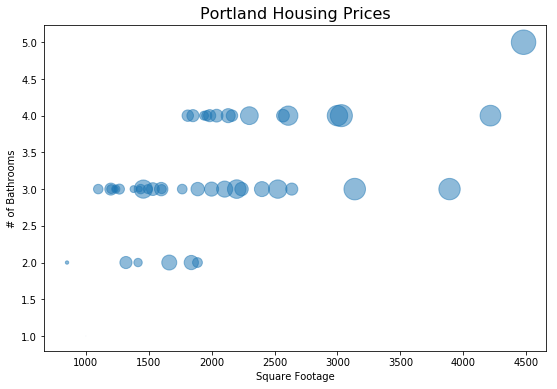

In [156]:
bubble_sizes = 600 * (y - y.min() + 1) / (y.max() - y.min())

fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(X[:,0], X[:,1], s=bubble_sizes, alpha=0.5, linewidths=1)
plt.title('Portland Housing Prices', fontsize=16)
plt.xlabel('Square Footage')
plt.ylabel('# of Bathrooms')
plt.show()

## Feature Scaling

In [157]:
# Normalize features and add bias column.
X_scaled, col_means, col_stds = scale_features(X)
X_scaled = np.column_stack((np.ones(m), X_scaled))

print(f'Feature means: {col_means}')
print(f'Feature standard deviations: {col_stds}')

Feature means: [2000.68085106    3.17021277]
Feature standard deviations: [7.86202619e+02 7.52842809e-01]


## Gradient Descent

Converged after 700 iterations.
Weights: [340412.65957447 109447.7864647   -6578.34484922]


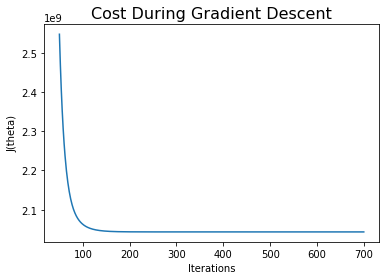

In [175]:
theta_multi = np.zeros(n+1)
alpha = 0.05
iterations = 1000

theta_m_vals, costs = gradient_descent(X_scaled, y,
                                       theta_multi,
                                       alpha, 
                                       iterations)
print('Weights:', theta_m_vals)

fig, ax = plt.subplots()
ax.plot(range(50, len(costs)), costs[50:])
plt.title('Cost During Gradient Descent', fontsize=16)
plt.xlabel('Iterations')
plt.ylabel('J(theta)')
plt.show()

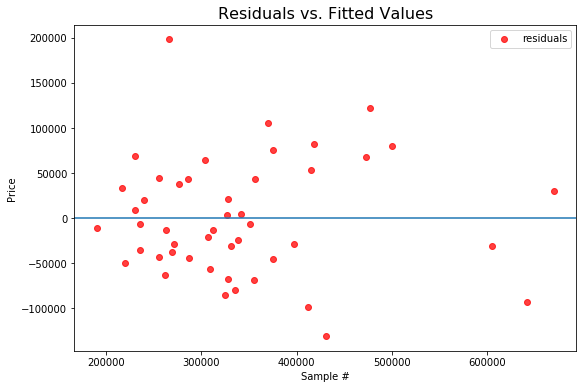

In [176]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(price_preds, y - price_preds, alpha=0.75, color='red', 
        label='residuals')
ax.axhline(y=0)
plt.title('Residuals vs. Fitted Values', fontsize=16)
plt.xlabel('Sample #')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()

In [178]:
sample_house = np.array([[1650, 3]])
sample_pred = scale_predict(sample_house, theta_m_vals, col_means, col_stds)

print('Sample prediction: 1650 sq ft, 3 bedrooms:\n${}'\
      .format(np.squeeze(np.round(sample_pred, 2))))

Sample prediction: 1650 sq ft, 3 bedrooms:
$293081.47


## Normal Equation

For comparison, use the normal equation to find theta values.

In [180]:
norm_eq_theta = normal_equation(X_scaled, y)
norm_prediction = scale_predict(np.array([[1650, 3]]), norm_eq_theta,
                                col_means, col_stds)

print('Theta values from normal equation:\n{}'.format(norm_eq_theta))
print('\nSample prediction: 1650 sq feet, 3 bedrooms')
print(f'${np.squeeze(norm_prediction):.2f}')

Theta values from normal equation:
[340412.65957447 109447.79646964  -6578.35485416]

Sample prediction: 1650 sq feet, 3 bedrooms
$293081.46


# scikit-learn Implementation

For comparison, let's train a roughly equivalent model using scikit-learn.

In [182]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Load data and split into X and y dataframes.
df = pd.read_csv(r'data/ex1data2.txt', names=['square_ft','bedrooms','price'])
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [183]:
# IN PROGRESS - BUILDING PIPELINE TO STREAMLINE FIT/PREDICT PROCESS
pipe = Pipeline([('sc', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
mses = cross_val_score(pipe, X_train, y_train, cv=3, 
                       scoring='neg_mean_squared_error')
j = -np.mean(mses)
weights_skl = np.array([pipe.named_steps['lr'].intercept_, 
                        *pipe.named_steps['lr'].coef_])

print('Mean squared error: ' + str(j))
print('Weights: ' + str(weights_skl))

Mean squared error: 3944431464.7347946
Weights: [331079.85714286 116563.85274984 -10055.30197917]


In [191]:
test_preds = pipe.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_df = pd.DataFrame(data=np.column_stack((X_test, y_test, test_preds)),
          columns=['square_ft', 'bedrooms', 'actual_price', 'predictions'])
#test_df['actual'] = y_test.reset_index(drop=True)

print('Test set - mean squared error: ' + str(test_mse) + '\n')
print(test_df)

Test set - mean squared error: 6308513967.943877

    square_ft  bedrooms  actual_price    predictions
0      2300.0       4.0      449900.0  364980.978636
1      2040.0       4.0      314900.0  329462.338845
2      3137.0       3.0      579900.0  492140.414223
3      1985.0       4.0      299900.0  321948.780427
4      2400.0       3.0      369000.0  391458.731429
5      2104.0       3.0      399900.0  351022.126128
6      1767.0       3.0      252900.0  304984.504552
7      3000.0       4.0      539900.0  460608.085767
8      1811.0       4.0      285900.0  298178.613797
9      1236.0       3.0      199900.0  232444.513285
10     1888.0       2.0      255000.0  334331.070558
11     1458.0       3.0      464500.0  262771.967261


In [192]:
sample_pred_skl = pipe.predict([[1650, 3]])
print('Sample prediction (1650 sq ft, 3 bathrooms): $' + 
      str(np.squeeze(sample_pred_skl)))

Sample prediction (1650 sq ft, 3 bathrooms): $289001.1166453474


# old method - no pipeline

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

# Perform feature scaling.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

# Fit linear regression model to data and predict price for sample house.
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
theta0 = lr.intercept_
theta1, theta2 = lr.coef_
print('Theta values:', theta0, theta1, theta2)

sample_pred_old = sc.transform(np.array([1650, 3]).reshape(1, -1))
prediction = lr.predict(sample_pred_old)
print(f'Predict new example: 1650 square feet, 3 bedrooms\n${prediction[0]:.2f}')

Theta values: 346168.45714285714 117213.21887065322 -6237.215777593505
Predict new example: 1650 square feet, 3 bedrooms
$297760.49
